### TCR Analysis: TB Progression/Control Clonality
#### Naraen Palanikumar

The objective of this notebook is to complete a bioinformatic analysis of publicly available scTCRseq data from this paper (https://doi.org/10.1038/s41591-022-02110-9) concerning patient TCR repertoires associated with control/progression of infection from Mycobacterium tuberculosis (TB). This analysis will closely mirror the analysis I completed for the paper recently published in the Journal "Frontiers in Immunology" as a part of Dr. Malloy's lab at the Uniformed Services University.

In [1]:
#imports section
import pandas as pd
import numpy as np
from tcrdist.adpt_funcs import import_adaptive_file
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
#auxiliary functions necessary for analysis
def standardize_gene_name(series):
    '''Converts V and J genes names to proper IMGT format'''
    series = series.str.strip()
    series = series.str.upper()
    series = series.str.split('*').str[0]
    series = series.str.replace(r'TRBV0', 'TRBV', regex = True)
    series = series.str.replace(r'TRBJ0', 'TRBJ', regex = True)
    series = series.str.replace(r'TCRBV', 'TRBV', regex = True)
    series = series.str.replace(r'TCRBJ', 'TRBJ', regex = True)
    series = series.str.replace(r'(TRB[V])(\d+)$', r'\1\2-1', regex=True)
    series = series.str.replace(r'(TRB[J])(\d+)$', r'\1\2-1', regex=True)
    return series

def standardize_CDR3(series):
    '''Standardizes the CDR3s as well for good measure'''
    series = series.astype(str).str.strip().str.upper()
    return series

def calculate_clonality(df, count_col = 'templates'):
    '''Calculates clonality of sample file'''
    if df.empty or count_col not in df.columns:
        return np.nan

    total_templates = df[count_col].sum()
    if total_templates == 0:
        return np.nan

    num_unique_clones = len(df)
    if num_unique_clones == 1:
        return 1.0
    
    if num_unique_clones == 0:
        return np.nan

    df['p_i'] = df[count_col] / total_templates

    entropy = -np.sum(df['p_i'] * np.log(df['p_i']))

    normalized_clonality = 1 - (entropy / np.log(num_unique_clones))
    return normalized_clonality

def format_p_value(p):
    '''Formatting the P value string from the Mann-Whitney test'''
    if p < 0.001:
        return 'P < 0.001'
    return f'P = {p:.3f}'

In [3]:
#external reference set collection/cleaning/standardization/combining
iedb = pd.read_csv("datasets/reference/iedb.csv")
vdjdb = pd.read_csv("datasets/reference/vdjdb.tsv", sep = '\t')

iedb.dropna(inplace = True)
iedb = iedb[iedb['Epitope - Source Organism'].str.contains("Mycobacterium tuberculosis")]
iedb["V"] = standardize_gene_name(iedb["Chain 2 - Curated V Gene"])
iedb["J"] = standardize_gene_name(iedb["Chain 2 - Curated J Gene"])
iedb["CDR3"] = standardize_CDR3(iedb["Chain 2 - CDR3 Curated"])
iedb = iedb[['CDR3', 'V', 'J']]

vdjdb = vdjdb[['CDR3', 'V', 'J']]
vdjdb.dropna(inplace = True)
vdjdb["V"] = standardize_gene_name(vdjdb["V"])
vdjdb["J"] = standardize_gene_name(vdjdb["J"])
vdjdb["CDR3"] = standardize_CDR3(vdjdb["CDR3"])

ext_set = pd.concat([vdjdb, iedb], ignore_index=True)
ext_set = ext_set[ext_set['V'].str.startswith('TRB', na = False)].copy()
ext_set = ext_set[ext_set['J'].str.startswith('TRB', na = False)].copy()
ext_set.drop_duplicates(keep = 'first', inplace = True)

In [4]:
#import all our experimental file and put them into progressor and controller lists
meta = pd.read_csv("datasets/experimental/metadata/samplekey.csv")
expfile_path = glob.glob(os.path.join('datasets/experimental/samples', '*.tsv'))

proglist = []
contlist = []

for file in expfile_path:
    name = os.path.basename(file)[:-9] #removes the _TCRB at the end of each file, leaving only the sample ID

    if name in meta["Sample.ID"].values:
        df = import_adaptive_file(file)
        df = df.dropna(subset = ['cdr3_b_aa', 'v_b_gene', 'j_b_gene', 'templates'])
        df = df[~df['cdr3_b_aa'].str.contains(r'\*', na = False)]
        df['V'] = standardize_gene_name(df['v_b_gene'])
        df['J'] = standardize_gene_name(df['j_b_gene'])
        df['CDR3'] = standardize_CDR3(df['cdr3_b_aa'])
        df = df[['V', 'J', 'CDR3', 'templates']]
        df['sample_id'] = name
        
        
        if meta[meta["Sample.ID"] == name]["Group"].values == "Progressor":
            df['Group'] = 'Progressor'
            proglist.append(df)
        else:
            df['Group'] = 'Controller'
            contlist.append(df)

In [5]:
#calculates the clonality of each df within progressors and controllers
prog_tot_clon = []
cont_tot_clon = []

for i in proglist:
    prog_tot_clon.append(calculate_clonality(i))

for i in contlist:
    cont_tot_clon.append(calculate_clonality(i))

print(np.median(prog_tot_clon))
print(np.median(cont_tot_clon))

0.10058959663347733
0.09232203486670065


In [6]:
#calculates tb specific TCR total frequency among all templates and tb-specific TCR clonality
key_cols = ['CDR3', 'V', 'J']

prog_tb_clon = []
cont_tb_clon = []

prog_tb_freq = []
cont_tb_freq = []

for i in proglist:
    tot_temp = i['templates'].sum()
    i['freq_clon'] = i['templates'] / tot_temp

    merged = pd.merge(i, ext_set, on = key_cols, how = 'inner')

    prog_tb_freq.append(merged['freq_clon'].sum())
    q = calculate_clonality(merged)
    if np.isnan(q):
        print("NAN DETECTED (PROG)")
        cont_tb_clon.append(q)
    else:
        prog_tb_clon.append(q)

for i in contlist:
    tot_temp = i['templates'].sum()
    i['freq_clon'] = i['templates'] / tot_temp

    merged = pd.merge(i, ext_set, on = key_cols, how = 'inner')

    cont_tb_freq.append(merged['freq_clon'].sum())
    q = calculate_clonality(merged)
    if np.isnan(q):
        print("NAN DETECTED (CONT)")
        cont_tb_clon.append(q)
    else:
        cont_tb_clon.append(q)

print(np.nanmedian(prog_tb_clon))
print(np.nanmedian(prog_tb_freq))
print(np.nanmedian(cont_tb_clon))
print(np.nanmedian(cont_tb_freq))

NAN DETECTED (PROG)
0.09347087935841314
0.00016543271192971334
0.08490152989884037
0.0001768772064520758


/tmp/ipykernel_791371/1218737497.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_791371/1218737497.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_791371/1218737497.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


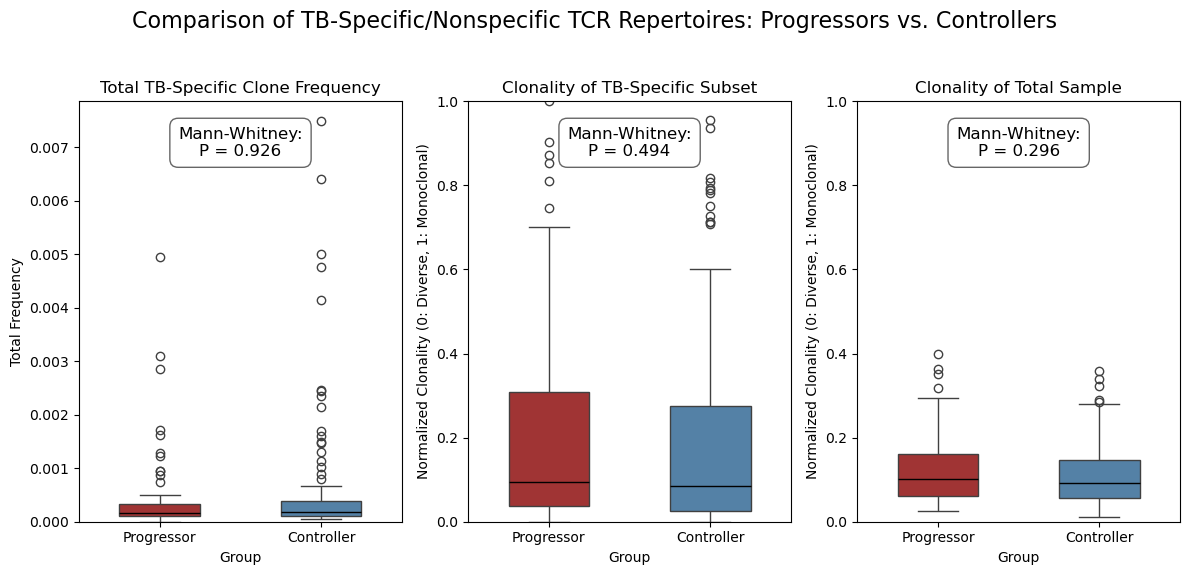

In [7]:
#compiles data and plots figure
data_tot_clon = {
    'Value': prog_tot_clon + cont_tot_clon,
    'Metric': ['Total Clonality'] * (len(prog_tot_clon) + len(cont_tot_clon)),
    'Group': ['Progressor'] * len(prog_tot_clon) + ['Controller'] * len(cont_tot_clon)
}
data_tb_freq = {
    'Value': prog_tb_freq + cont_tb_freq,
    'Metric': ['Total TB Frequency'] * (len(prog_tb_freq) + len(cont_tb_freq)),
    'Group': ['Progressor'] * len(prog_tb_freq) + ['Controller'] * len(cont_tb_freq)
}
data_tb_clon = {
    'Value': prog_tb_clon + cont_tb_clon,
    'Metric': ['TB Clonality'] * (len(prog_tb_clon) + len(cont_tb_clon)),
    'Group': ['Progressor'] * len(prog_tb_clon) + ['Controller'] * len(cont_tb_clon)
}

plot_df = pd.concat([pd.DataFrame(data_tot_clon), pd.DataFrame(data_tb_freq), pd.DataFrame(data_tb_clon)])

freq_prog = plot_df[(plot_df['Metric'] == 'Total TB Frequency') & (plot_df['Group'] == 'Progressor')]['Value']
freq_cont = plot_df[(plot_df['Metric'] == 'Total TB Frequency') & (plot_df['Group'] == 'Controller')]['Value']
clon_prog = plot_df[(plot_df['Metric'] == 'TB Clonality') & (plot_df['Group'] == 'Progressor')]['Value']
clon_cont = plot_df[(plot_df['Metric'] == 'TB Clonality') & (plot_df['Group'] == 'Controller')]['Value']
tclon_prog = plot_df[(plot_df['Metric'] == 'Total Clonality') & (plot_df['Group'] == 'Progressor')]['Value']
tclon_cont = plot_df[(plot_df['Metric'] == 'Total Clonality') & (plot_df['Group'] == 'Controller')]['Value']

clon_prog_cl = np.nan_to_num(clon_prog, nan = np.nanmedian(prog_tb_clon)) #correcting for the nan detected
clon_cont_cl = np.nan_to_num(clon_cont, nan = np.nanmedian(cont_tb_clon))

stat_freq, p_freq = stats.mannwhitneyu(freq_prog, freq_cont, alternative='two-sided')
stat_clon, p_clon = stats.mannwhitneyu(clon_prog_cl, clon_cont_cl, alternative='two-sided')
stat_tclon, p_tclon = stats.mannwhitneyu(tclon_prog, tclon_cont, alternative='two-sided')

fig, axes = plt.subplots(1, 3, figsize = (12, 6), sharey = False)

palette = {'Progressor': 'firebrick', 'Controller': 'steelblue'}

ax = axes[0]
sns.boxplot(
    data = plot_df[plot_df['Metric'] == 'Total TB Frequency'],
    x = 'Group', y = 'Value', palette = palette, width = 0.5, ax = ax, medianprops = {'color': 'black'}
)
ax.set_title('Total TB-Specific Clone Frequency')
ax.set_ylabel('Total Frequency')
p_val_text = format_p_value(p_freq)
ax.text(0.5, 0.87, f'Mann-Whitney:\n{p_val_text}', 
        transform = ax.transAxes, ha = 'center', fontsize = 12, 
        bbox = dict(boxstyle = "round,pad=0.5", fc = "white", alpha = 0.6))
ax.set_ylim(bottom = 0)


ax = axes[1]
sns.boxplot(
    data = plot_df[plot_df['Metric'] == 'TB Clonality'],
    x = 'Group', y = 'Value', palette = palette, width = 0.5, ax = ax, medianprops = {'color': 'black'}
)
ax.set_title('Clonality of TB-Specific Subset')
ax.set_ylabel('Normalized Clonality (0: Diverse, 1: Monoclonal)')
ax.set_ylim(0, 1)
p_val_text = format_p_value(p_clon)
ax.text(0.5, 0.87, f'Mann-Whitney:\n{p_val_text}', 
        transform = ax.transAxes, ha = 'center', fontsize = 12, 
        bbox=dict(boxstyle = "round,pad=0.5", fc = "white", alpha = 0.6))

ax = axes[2]
sns.boxplot(
    data = plot_df[plot_df['Metric'] == 'Total Clonality'],
    x = 'Group', y = 'Value', palette = palette, width = 0.5, ax = ax, medianprops = {'color': 'black'}
)
ax.set_title('Clonality of Total Sample')
ax.set_ylabel('Normalized Clonality (0: Diverse, 1: Monoclonal)')
ax.set_ylim(0, 1)
p_val_text = format_p_value(p_tclon)
ax.text(0.5, 0.87, f'Mann-Whitney:\n{p_val_text}', 
        transform = ax.transAxes, ha = 'center', fontsize = 12, 
        bbox=dict(boxstyle = "round,pad=0.5", fc = "white", alpha = 0.6))

plt.suptitle('Comparison of TB-Specific/Nonspecific TCR Repertoires: Progressors vs. Controllers', fontsize = 16)
plt.tight_layout(rect = [0, 0.03, 1, 0.95])
plt.show()

### Conclusions

As can be seen from the figure above, there doesn't seem to be any sort of strong correlation between TCR-B clonality/frequency (both total and TB-specific) and the subject status as a progressor or controller of the disease. Prior to this analysis, I hypothesized that progressors would have slightly higher clonalities due to my belief that a more monoclonal leaning repertoire would be associated with progression of the disease due to the immune system's inability to adapt quickly enough to the wide variety of antigens presented by M.tb. We can see visually, that this does seem to be the case somewhat, but as the differences aren't really statistically significant, we do not have enough evidence as of yet to make any certain claims.